In [ ]:
import requests
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from transformers import pipeline
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Initialize SpaCy and transformers models
nlp = spacy.load('en_core_web_sm')
summarizer = pipeline('summarization', model='facebook/bart-large-cnn')

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
API_KEY = 'bcf8082cc62342c2ad155e9399aa6a03'
url = 'https://newsapi.org/v2/everything'
params = {
    'q': 'supply chain disruption OR supplier risk OR logistics delay',
    'language': 'en',
    'pageSize': 100,
    'apiKey': API_KEY
}

In [ ]:
# Fetch and load data
response = requests.get(url, params=params)
news_data = response.json()


In [ ]:
# Convert articles to DataFrame
articles = news_data.get('articles', [])
df = pd.DataFrame(articles)
df = df[['title', 'description', 'url', 'publishedAt', 'content']]

In [ ]:
# Text preprocessing
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

In [ ]:
# Apply preprocessing
if not df.empty:
    df['cleaned_content'] = df['content'].apply(lambda x: preprocess_text(x) if x else '')

In [ ]:
# Named Entity Recognition (NER) with spaCy
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [ ]:
# Extract entities from cleaned content
df['entities'] = df['cleaned_content'].apply(lambda x: extract_entities(x) if x else [])

In [ ]:
def summarize_text(text):
    if text:
        return summarizer(text, max_length=60, min_length=20, do_sample=False)[0]['summary_text']
    return ''

df_subset = df.head(20)
df_subset['summary'] = df_subset['cleaned_content'].apply(summarize_text)

Your max_length is set to 60, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 60, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 60, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 60, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max

In [ ]:
# Visualize entity connections with NetworkX
G = nx.Graph()

In [ ]:
# Add edges based on entities in each article
for _, row in df.iterrows():
    entities = [ent[0] for ent in row['entities'] if ent[1] in ['ORG', 'GPE']]
    for i in range(len(entities) - 1):
        G.add_edge(entities[i], entities[i + 1], weight=1)

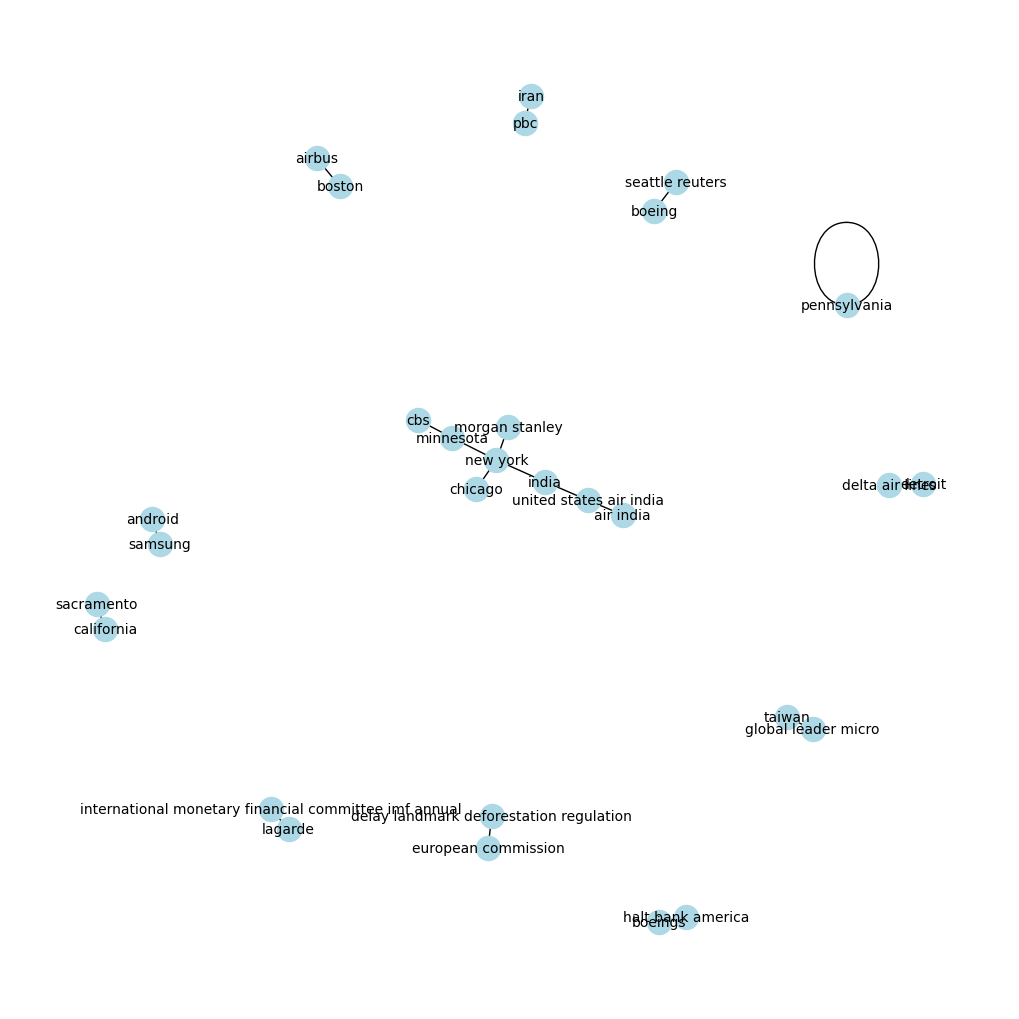

In [ ]:
# Plot the graph
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color='lightblue', font_size=10)
plt.show()

In [ ]:
# Risk assessment and suggestion of alternative suppliers
entity_risk = {}

In [ ]:
# Calculate entity risk scores
for _, row in df.iterrows():
    for entity in row['entities']:
        entity_risk[entity[0]] = entity_risk.get(entity[0], 0) + 1

In [ ]:
def suggest_alternatives(risky_entity):
    sorted_risk = sorted(entity_risk.items(), key=lambda x: x[1])
    alternatives = [ent for ent, score in sorted_risk if ent != risky_entity][:3]
    return alternatives

In [ ]:
# Example usage
risky_supplier = 'SupplierA'
alternatives = suggest_alternatives(risky_supplier)
print(f"Alternatives for {risky_supplier}: {alternatives}")

Alternatives for SupplierA: ['michael', 'li ryanair', 'third']


In [ ]:
def generate_scenario(description):
    return f"Generated scenario based on: {description}"

In [ ]:
for index, row in df_subset.iterrows():
    scenario = generate_scenario(row['description'])
    print(f"Scenario for '{row['title']}': {scenario}")

Scenario for 'OLED MacBook Air Could Be Delayed Beyond 2027, Claims Report': Generated scenario based on: Apple's plans to release a MacBook Air with an OLED display may face significant delays beyond its original expected 2027 launch window, according to a new report from The Elec.





Industry sources cited by the Korean outlet point to pricing concerns and su…
Scenario for 'Boeing delays are wreaking havoc with the airline industry's plans, and flyers may well feel the pain': Generated scenario based on: Ryanair CEO Michael O'Leary expects delivery delays to reduce its growth next year, while Emirates is frustrated with the yet-to-be-certified 777X.
Scenario for 'Boeing's new CEO vows to make it 'iconic' again after posting $6.1 billion loss in his 1st earnings': Generated scenario based on: "With the right focus and culture, we can be an iconic company and aerospace leader once again," said Boeing CEO Kelly Ortberg
Scenario for 'Revolutionizing Supply Chains: The Game-Changing Imp